# Bonus - Descriptive Notebook

*Author*: Michael Haines | mhaines2@illinois.edu

This notebook provides a summary of results. It depends on successful running of the `Pre-processing.ipynb` notebook to process the raw data. The outputs are displayed so that the reader can learn from this notebook without the requirement of reproducing the experiments.

In [21]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchmetrics import AUROC
from torchmetrics import AveragePrecision
from torchmetrics import Precision
from torchmetrics import Recall
from sklearn.metrics import roc_curve

## Reproducibility Summary

For my study, I performed the following key tasks:

- Extracted a cohort from the MIMIC-IV EHR dataset, extracted features for the cohort, and tokenized the dataset so that it could be used to train the BERT-based models
- Trained 3 models:
    - Fine-tuned a public checkpoint of BERT on a small sample of data
    - Fine-tuned a public checkpoint of BERT on a larger sample of data
    - Fine-tuned a custom checkpoint, created by applying masked language modeling and few shot learning with EHR data, in an adversarial setting

In conclusion, I was able to validate the original study’s findings that the model that went through the pre-training task and was fine-tuned in an adversarial setting out-performed the open-source checkpoint of BERT, exhibiting a superior AUROC of 0.8448, vs. an AUROC of 0.8372 for the model that was fine-tuned on the open-source checkpoint of BERT. This reinforces the efficacy of the architecture proposed by the authors. Despite the open-source checkpoint of BERT most likely being trained on a significantly larger data set, this proves that the masked language modeling task done in the context of EHR creates a significantly more robust model.

## Visualization of Data Statistics

This study sourced its data from the [MIMIC-IV data set](https://physionet.org/content/mimiciv/2.2/), an open-source EHR dataset that requires pre-authorization to access. The following charts show the distributions of the key fields from the cohort used in the study.

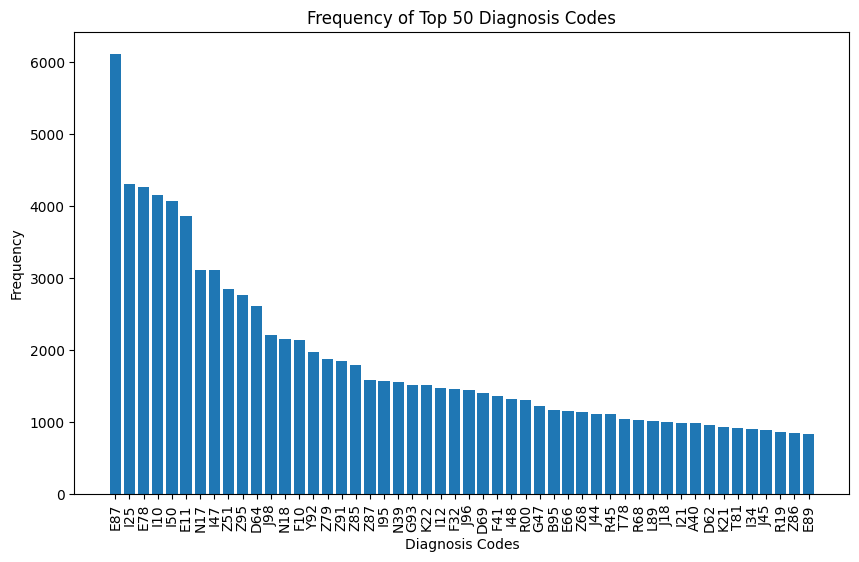

In [ ]:
if not os.path.exists(f"./images"):
    os.makedirs(f"./images")

df = pd.read_csv(f'./data/full/summary/diag_summary.csv')
df = df.sort_values('total_count', ascending=False)
N = 50
top_diagnoses = df.iloc[:N]

# create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(1, N), top_diagnoses['total_count'])
plt.xlabel('Diagnosis Codes')
plt.ylabel('Frequency')
plt.xticks(range(1, N), top_diagnoses['new_icd_code'], rotation="vertical")
plt.title('Frequency of Top ' + str(N) + ' Diagnosis Codes')
plt.savefig(f'images/{path}/diag_freq.png')
plt.show()

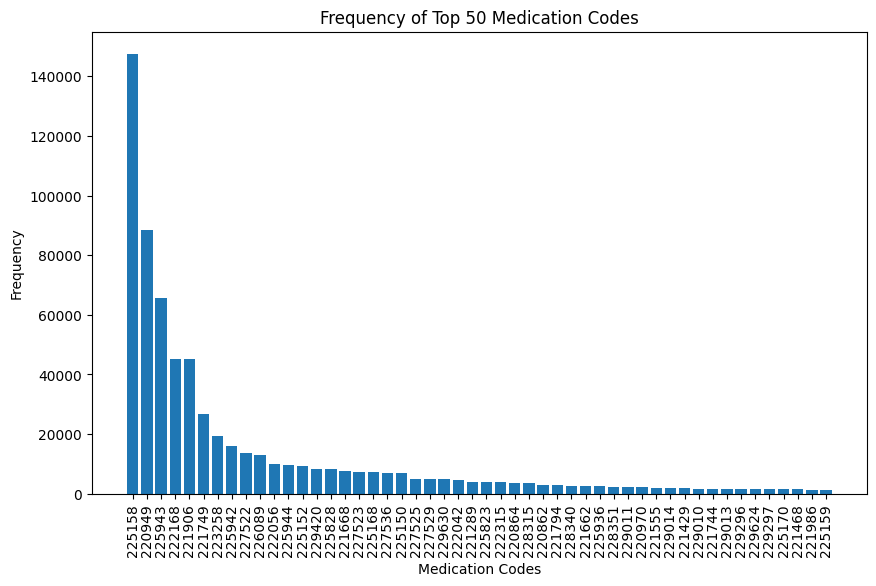

In [ ]:
df = pd.read_csv(f'./data/{path}/summary/med_summary.csv')
df = df.sort_values('total_count', ascending=False)
N = 50
top_diagnoses = df.iloc[:N]

# create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(1, N), top_diagnoses['total_count'])
plt.xlabel('Medication Codes')
plt.ylabel('Frequency')
plt.xticks(range(1, N), top_diagnoses['itemid'], rotation="vertical")
plt.title('Frequency of Top ' + str(N) + ' Medication Codes')
plt.savefig(f'images/{path}/med_freq.png')
plt.show()

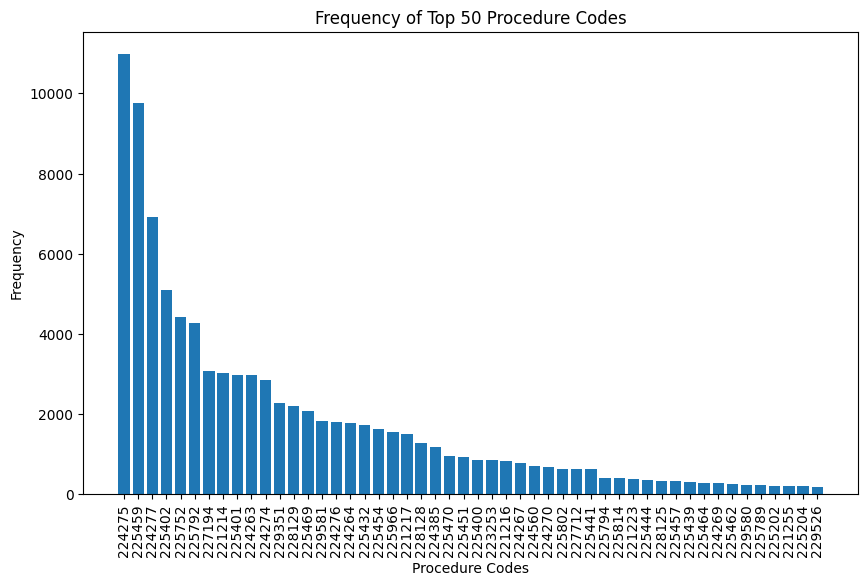

In [ ]:
df = pd.read_csv(f'./data/{path}/summary/proc_summary.csv')
df = df.sort_values('total_count', ascending=False)
N = 50
top_diagnoses = df.iloc[:N]

# create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(1, N), top_diagnoses['total_count'])
plt.xlabel('Procedure Codes')
plt.ylabel('Frequency')
plt.xticks(range(1, N), top_diagnoses['itemid'], rotation="vertical")
plt.title('Frequency of Top ' + str(N) + ' Procedure Codes')
plt.savefig(f'images/{path}/proc_freq.png')
plt.show()

## Methodology Explanation

Please see the `ModelTraining.ipynb` notebook for information about reproducing the experiments. This code cannot be run here, as it requires GPU acceleration. In that notebook, I performed 4 tasks:

- Fine-tuned a [checkpointed BERT model](https://pypi.org/project/pytorch-pretrained-bert/) on EHR data using a small sample cohort
- Fine-tuned a [checkpointed BERT model](https://pypi.org/project/pytorch-pretrained-bert/) on EHR data using the full cohort
- Pre-trained a raw BERT model myself using the full cohort's data
- Fine-tuned the model from step 3 in an adversarial setting using the full cohort's data

## Illustration of the Results

Below, we show illustrations of the ROC curve for each of the three models that were trained.


In [26]:
def show_results(data, model):
    labels = pd.read_csv(f"./data/{data}/eval/{model}/labels.csv", header=None)
    preds = pd.read_csv(f"./data/{data}/eval/{model}/preds.csv", header=None)

    labels=labels.drop(0, axis=1)
    preds=preds.drop(0, axis=1)

    preds = torch.sigmoid(torch.FloatTensor(preds.values))
    labels = torch.IntTensor(labels.values)

    auroc = AUROC(task="binary", pos_label=1)
    print("AUROC: " + str(auroc(preds, labels)))
    
    labels = np.array(labels)
    predictions = np.array(preds)

    fpr, tpr, thresholds = roc_curve(labels, predictions)

    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.savefig(f'./images/{data}_{model}_roc.png')
    plt.show()

### Model 1 - Public Checkpoint Fine-tuned on Sample Cohort

AUROC: tensor(0.6266)


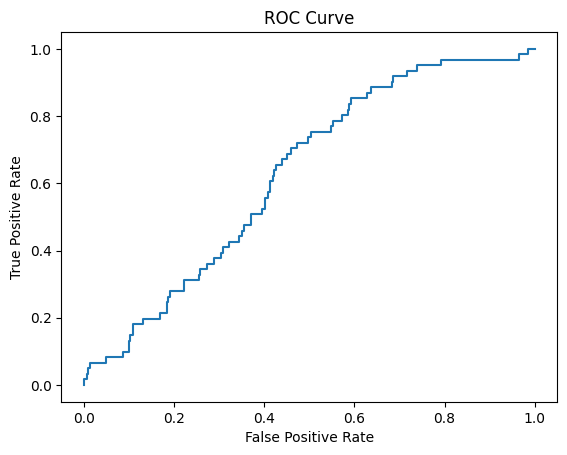

In [27]:
show_results("sample", "behrt")

### Model 2 - Public Checkpoint Fine-tuned on Full Cohort

AUROC: tensor(0.8372)


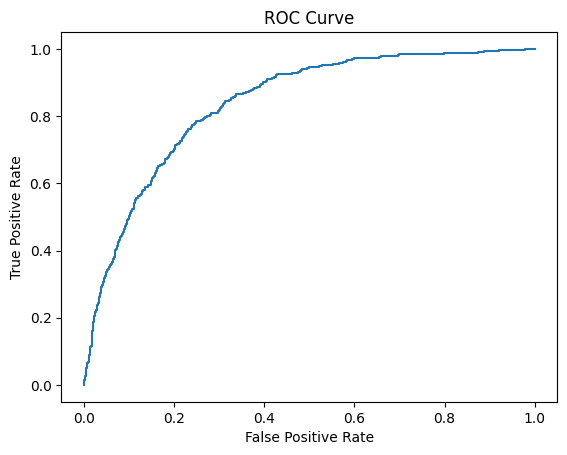

In [28]:
show_results("full", "behrt")

### Model 3 - Custom Checkpoint Fine-tuned on Full Cohort in Adversarial Setting

AUROC: tensor(0.8448)


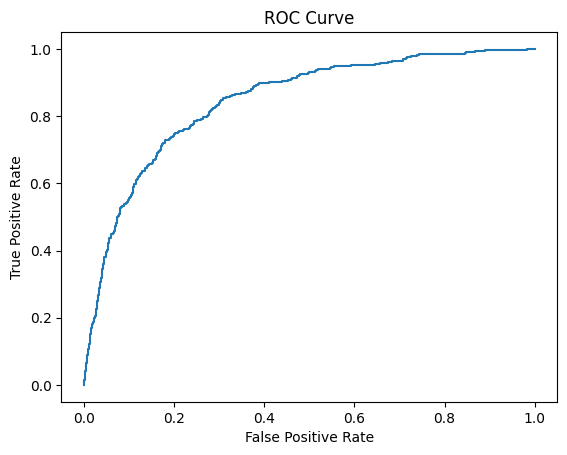

In [30]:
show_results("full", "custom")